
# Transfer Learning for Computer Vision Tutorial
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the ConvNet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
import os
import shutil

def copy_images(data_dir, destination_dir, test_size=0.2):
    # Create train and val directories in the destination folder
    os.makedirs(os.path.join(destination_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(destination_dir, 'val'), exist_ok=True)

    # List all subdirectories in data_dir
    class_directories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    # Iterate through each subdirectory in data_dir
    for class_dir in class_directories:
        class_path = os.path.join(data_dir, class_dir)

        # List all images in the class directory
        all_images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Check if there are enough samples to split
        if len(all_images) < 2:
            print(f"Skipping {class_dir} as it doesn't have enough samples.")
            continue

        # Split the images into train and val sets
        train_images, val_images = train_test_split(all_images, test_size=test_size, random_state=42)

        # Create train and val directories for each class in the destination folder
        os.makedirs(os.path.join(destination_dir, 'train', class_dir), exist_ok=True)
        os.makedirs(os.path.join(destination_dir, 'val', class_dir), exist_ok=True)

        # Copy files to train directory in the destination folder
        for file in train_images:
            src = os.path.join(class_path, file)
            dest = os.path.join(destination_dir, 'train', class_dir, file)
            shutil.copy(src, dest)

        # Copy files to val directory in the destination folder
        for file in val_images:
            src = os.path.join(class_path, file)
            dest = os.path.join(destination_dir, 'val', class_dir, file)
            shutil.copy(src, dest)

# Example usage
data_dir = '/content/drive/MyDrive/project/JEM207_Project/Merged'
destination_dir = '/content/drive/MyDrive/project/JEM207_Project/FinalData'
copy_images(data_dir, destination_dir, test_size=0.2)


In [12]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
import torch
from torchvision import datasets, transforms

# Define transform without normalization for loading dataset
raw_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load dataset without normalization
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/project/JEM207_Project/FinalData/train', transform=raw_transform)

# Initialize variables to accumulate sum of pixel values and squared sum of pixel values
channel_sum = torch.zeros(3)
channel_squared_sum = torch.zeros(3)

# Iterate through the dataset to compute the sum of pixel values and squared sum of pixel values
for img, _ in dataset:
    channel_sum += torch.mean(img, dim=(1, 2))  # Compute mean along height and width dimensions
    channel_squared_sum += torch.mean(img ** 2, dim=(1, 2))  # Compute squared mean along height and width dimensions

# Calculate the mean and standard deviation for each channel
mean = channel_sum / len(dataset)
std = torch.sqrt(channel_squared_sum / len(dataset) - mean ** 2)

print("Mean:", mean)
print("Standard Deviation:", std)


Mean: tensor([0.3750, 0.3984, 0.4250])
Standard Deviation: tensor([0.2682, 0.2669, 0.2715])


## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [13]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.3750, 0.3984, 0.4250], [0.2682, 0.2669, 0.2715])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.3750, 0.3984, 0.4250], [0.2682, 0.2669, 0.2715])
    ]),
}

data_dir = '/content/drive/MyDrive/project/JEM207_Project/FinalData'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



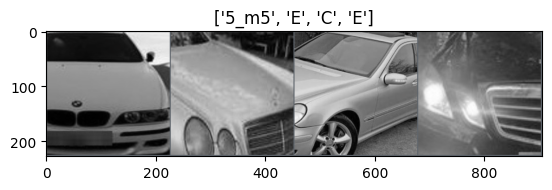

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.3750, 0.3984, 0.4250])
    std = np.array([0.2682, 0.2669, 0.2715])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
len(class_names)

63

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 63)
# model_ft.load_state_dict(torch.load('/content/drive/MyDrive/MakeModel_Rec.pt'))  # Change 'cpu' to 'cuda' if you're using GPU


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=70)

Epoch 0/69
----------
train Loss: 0.6302 Acc: 0.8266
val Loss: 0.4590 Acc: 0.8817

Epoch 1/69
----------
train Loss: 0.6209 Acc: 0.8245
val Loss: 0.4588 Acc: 0.8845

Epoch 2/69
----------
train Loss: 0.6089 Acc: 0.8277
val Loss: 0.4523 Acc: 0.8856

Epoch 3/69
----------
train Loss: 0.6147 Acc: 0.8243
val Loss: 0.4422 Acc: 0.8878

Epoch 4/69
----------
train Loss: 0.6147 Acc: 0.8232
val Loss: 0.4556 Acc: 0.8856

Epoch 5/69
----------
train Loss: 0.6263 Acc: 0.8266
val Loss: 0.4551 Acc: 0.8828

Epoch 6/69
----------
train Loss: 0.6337 Acc: 0.8246
val Loss: 0.4726 Acc: 0.8767

Epoch 7/69
----------
train Loss: 0.6172 Acc: 0.8235
val Loss: 0.4513 Acc: 0.8834

Epoch 8/69
----------
train Loss: 0.6139 Acc: 0.8322
val Loss: 0.4502 Acc: 0.8817

Epoch 9/69
----------
train Loss: 0.6227 Acc: 0.8298
val Loss: 0.4762 Acc: 0.8729

Epoch 10/69
----------
train Loss: 0.6185 Acc: 0.8266
val Loss: 0.4481 Acc: 0.8900

Epoch 11/69
----------
train Loss: 0.6178 Acc: 0.8245
val Loss: 0.4535 Acc: 0.8850

Ep

In [14]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 63)
model_ft.load_state_dict(torch.load('/content/drive/MyDrive/MakeModel_Rec.pt',map_location=torch.device('cpu')))  # Change 'cpu' to 'cuda' if you're using GPU


# model_ft = model_ft.to÷(device)

<All keys matched successfully>

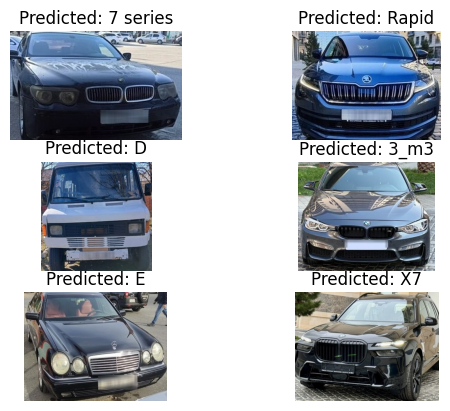

In [16]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image

def visualize_model(model, data_dir, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if images_so_far == num_images:
                model.train(mode=was_training)
                plt.show()
                return

            # Load the original image
            img_path = os.path.join(root, file)
            img = Image.open(img_path)
            o_img = img.copy()
            # Display the image
            images_so_far += 1

            # Preprocess the image and get the prediction
            img = data_transforms['val'](img).unsqueeze(0)  # Assuming transform is defined elsewhere
            inputs = img.to(device)  # Assuming device is defined elsewhere
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title(f'Predicted: {class_names[preds.item()]}')
            plt.imshow(o_img)
            # Display the predicted class
            # ax = plt.subplot(num_images//2, 2, images_so_far+1)
            # ax.axis('off')
            # ax.set_title(f'Predicted: {class_names[preds.item()]}')

            # Show the transformed image
            # plt.imsh÷ow(data_transforms['val'](img.squeeze(0)).permute(1, 2, 0))  # Assuming transform is defined elsewhere

    # model.train(mod÷e=was_training)
    # plt.show()
visualize_model(model_ft, '/content/drive/MyDrive/project/JEM207_Project/Viz', class_names, 6)


In [17]:
file_path = 'output.txt'

# Open the file in write mode ('w')
with open(file_path, 'w') as file:
    # Iterate over each item in the list
    for item in class_names:
        # Write each item to a new line in the file
        file.write("%s\n" % item)

In [18]:
# Define a dictionary mapping short versions to human-readable versions
car_mapping = {
    '0403': 'Mercedes-Benz 0403',
    '1 series': 'BMW 1 Series',
    '1217': 'Mercedes-Benz 1217',
    '190': 'Mercedes-Benz 190',
    '2 series': 'BMW 2 Series',
    '3_m3': 'BMW 3 Series',
    '4_m4': 'BMW 4 Series',
    '5_m5': 'BMW 5 Series',
    '6_m6': 'BMW 6 Series',
    '7 series': 'BMW 7 Series',
    'A': 'Mercedes-Benz A-Class',
    'Actros': 'Mercedes-Benz Actros',
    'Atego': 'Mercedes-Benz Atego',
    'Axor': 'Mercedes-Benz Axor',
    'B': 'Mercedes-Benz B-Class',
    'C': 'Mercedes-Benz C-Class',
    'CL': 'Mercedes-Benz CL-Class',
    'CLA': 'Mercedes-Benz CLA-Class',
    'CLK': 'Mercedes-Benz CLK-Class',
    'CLS': 'Mercedes-Benz CLS-Class',
    'Citan': 'Mercedes-Benz Citan',
    'D': 'Mercedes-Benz D-Class',
    'E': 'Mercedes-Benz E-Class',
    'EQC': 'Mercedes-Benz EQC',
    'EQS': 'Mercedes-Benz EQS',
    'Fabia': 'Skoda Fabia',
    'G': 'Mercedes-Benz G-Class',
    'GL': 'Mercedes-Benz GL-Class',
    'GLA': 'Mercedes-Benz GLA-Class',
    'GLB': 'Mercedes-Benz GLB-Class',
    'GLC': 'Mercedes-Benz GLC-Class',
    'GLE': 'Mercedes-Benz GLE-Class',
    'GLK': 'Mercedes-Benz GLK-Class',
    'GLS': 'Mercedes-Benz GLS-Class',
    'Gt': 'Mercedes-Benz GT-Class',
    'Kamiq': 'Skoda Kamiq',
    'Karoq': 'Skoda Karoq',
    'Kodiaq': 'Skoda Kodiaq',
    'ML': 'Mercedes-Benz ML-Class',
    'Octavia': 'Skoda Octavia',
    'R': 'Mercedes-Benz R-Class',
    'Rapid': 'Skoda Rapid',
    'Roomster': 'Skoda Roomster',
    'S': 'Mercedes-Benz S-Class',
    'SLK': 'Mercedes-Benz SLK-Class',
    'Sprinter': 'Mercedes-Benz Sprinter',
    'Superb': 'Skoda Superb',
    'Vario': 'Mercedes-Benz Vario',
    'Vito': 'Mercedes-Benz Vito',
    'X1': 'BMW X1',
    'X2': 'BMW X2',
    'X3': 'BMW X3',
    'X4': 'BMW X4',
    'X5': 'BMW X5',
    'X6': 'BMW X6',
    'X7': 'BMW X7',
    'XM': 'BMW XM',
    'Yeti': 'Skoda Yeti',
    'i3': 'BMW i3',
    'i4': 'BMW i4',
    'i5': 'BMW i5',
    'i7': 'BMW i7',
    'iX': 'BMW iX'
}

# Define the short version list
short_version_list = [
    '0403', '1 series', '1217', '190', '2 series', '3_m3', '4_m4', '5_m5', '6_m6', '7 series',
    'A', 'Actros', 'Atego', 'Axor', 'B', 'C', 'CL', 'CLA', 'CLK', 'CLS', 'Citan', 'D', 'E', 'EQC',
    'EQS', 'Fabia', 'G', 'GL', 'GLA', 'GLB', 'GLC', 'GLE', 'GLK', 'GLS', 'Gt', 'Kamiq', 'Karoq',
    'Kodiaq', 'ML', 'Octavia', 'R', 'Rapid', 'Roomster', 'S', 'SLK', 'Sprinter', 'Superb', 'Vario',
    'Vito', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'XM', 'Yeti', 'i3', 'i4', 'i5', 'i7', 'iX'
]

# Map short versions to human-readable versions
human_readable_list = [car_mapping[car] for car in short_version_list]

# Write the human-readable list to a text file
with open('output1.txt', 'w') as file:
    for car in human_readable_list:
        file.write(car + '\n')


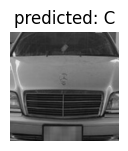

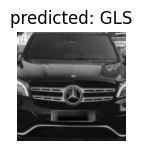

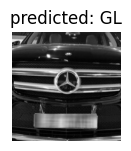

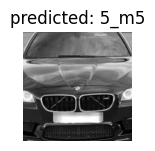

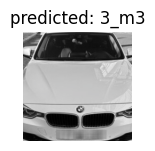

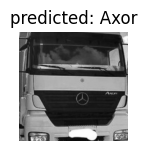

In [ ]:
visualize_model(model_ft)

In [ ]:
torch.save(model_ft.state_dict(), 'MakeModel_Rec.pt')
